In [1]:
save_posterior_grid_plot = FALSE

save_damped_proportion_pdf = TRUE

In [2]:
source("tools.R")

Warning message:
"package 'plyr' was built under R version 3.3.3"Warning message:
"package 'tidyverse' was built under R version 3.3.3"Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'tibble' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"Warning message:
"package 'purrr' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summa

In [14]:
library(gridExtra)

Warning message:
"package 'gridExtra' was built under R version 3.3.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [3]:
# Charley Wu packages
#packages <- c('plyr', 'jsonlite', 'ggplot2', 'gridExtra', 'reshape2', 'stargazer', 'coefplot', "grid", 'parallel', 'corrplot', 'rprojroot', 'MASS')
#lapply(packages, require, character.only = TRUE)

In [4]:
# Kernel composition name change
#l+r+p -> l+p+r
#l+r*p -> l+p*r
#l*r*p -> l*p*r

readable_kernel <- function(current_kernel){
    new_kernel <- current_kernel
    
    new_kernel <- ifelse(new_kernel == 'l+r+p', 'l+p+r', new_kernel)
    new_kernel <- ifelse(new_kernel == 'l+r*p', 'l+p*r', new_kernel)
    new_kernel <- ifelse(new_kernel == 'l*r*p', 'l*p*r', new_kernel)
    
    new_kernel <- gsub("\\*", "×", new_kernel)
    
    return(new_kernel)
}

# Get the range of a scenario
get_range <- function(scenario_name) {
    switch( scenario_name,
            'Temperature' = c(-10, 40),
            'Rain' = c(0, 100),
            'Sales' = c(0, 5000),
            'Gym members' = c(0, 50),
            'Salary' = c(0, 50),
            'FB Friends' = c(0, 1000))
}

kernels  <- c("l", "p", "r", "l+p", "l+r", "p+r", "l*r", "l*p", "p*r", "l+r+p", "l+r*p", "l*r+p", "l*p+r", "l*r*p")

# Plotting functions

In [5]:
plot_lmls <- function(prop_data, title='', scenario, hide_x=FALSE, hide_y=FALSE, red_border=TRUE) {
    
    # Best-fitting real-world data kernel composition
    rw_lmls <- read_csv("data/real-world/to-plot.csv")
    red_kernel <- (rw_lmls %>%
                    filter(scenario == !!scenario) %>%
                    summarize(red_kernel = kernel[which.max(lml)]))$red_kernel
    red_kernel <- readable_kernel(red_kernel)

    plot <- prop_data %>%
                ggplot(aes(x=kernel, y=value)) +
                    geom_bar(stat='identity') +
                    geom_bar(stat='identity', data=prop_data %>% filter(kernel == red_kernel), alpha=0, size=0.5, color="red") +
                    coord_cartesian (ylim=c(0, 1)) +
                    #labs(title = title) +
                    ggthemes::theme_few() +
                    xlab("Kernel composition") +
                    ylab("Likelihood") +
                    geom_errorbar(aes(ymin=as.numeric(lo_ci), ymax=as.numeric(hi_ci)),
                                      width=.3,
                                      position=position_dodge(.9)) +
                    scale_y_continuous(breaks = seq(0, 1, length.out=3)) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

In [57]:
plot_curves <- function(plot_data, plot_rwdata, ylab='', scenario, hide_x=FALSE, hide_y=FALSE) {

    # Min and max value of the data to be shown
    range_y <- get_range(scenario)
    limits_y <- c( min(range_y[1], min(plot_data$value)), max(range_y[2], max(plot_data$value)))
    
    # Mean trend
    trend <- plot_data %>% group_by(day) %>% summarize(mean_y = mean(value))
    
    # Resolution subsetting
    resolution = 10 #smaller number is higher resolution
    plot_data <- plot_data %>% filter((day - min(day)) %% resolution == 0)
    trend <- trend %>% filter((day - min(day)) %% resolution == 0)
    
    # Plotting
    plot <- plot_data %>%
                ggplot(aes(x=day, y=value, group=id)) +
                    geom_line(col="steelblue", alpha=0.2) + # Participants' curves
                    geom_line(data=plot_rwdata, aes(x=day, group=1), colour="red", alpha=0.6) + # Real world data
                    geom_line(data=trend, aes(x=day, y=mean_y, group=1), colour="black") + # Mean trend
                    #labs(title = title) +
                    ggthemes::theme_few() +
                    ylab(ylab) +
                    scale_x_continuous(breaks = c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
                    scale_y_continuous(breaks = seq(range_y[1], range_y[2], length.out=3), limits=limits_y) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          axis.text.y = element_text(angle = 90,  vjust = 0.5, hjust=0.5),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

# Prior: Kernel compositions bar plots

##### Import and prepare the data

In [58]:
data_prior <- read_csv("data/for_composititional_analysis_prior.csv")

# Get a "dictionary" of ID, PID, Scenario
dict_prior <- data_prior %>%                        
                        group_by(id, pid, scenario) %>%
                        summarize()

# Get the results of the LML analysis over the prior data
prior_results <- read_csv('output/minus-mean-treatment/results_prior_lmls.csv')

# Merge the results with the dictionary to have a 'full view' of the situation
lmls_prior <- merge(prior_results, dict_prior, by.x='cid', by.y='id', all.x=TRUE)

# Kernel composition name change
lmls_prior$kernel <- readable_kernel(lmls_prior$kernel)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double()
)
Parsed with column specification:
cols(
  cid = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)


In [59]:
# Removes the GPs that failed to be optimized in the second time. The lmls that failed to be optimized are also removed.
#Finaly, the lml_standard is calculated
lmls_prior_f <- lmls_prior %>%
                    filter(second_exception == 'False' & lml != -999999999)

sds <- lmls_prior_f %>% 
            group_by(kernel, scenario) %>%
            summarize(lo_bound = mean(lml) - 5*sd(lml), up_bound = mean(lml) + 5*sd(lml))

sds$ks <- paste0(sds$kernel, sds$scenario)

lmls_prior_f$ks <- paste0(lmls_prior_f$kernel, lmls_prior_f$scenario)

sds$kernel <- NULL
sds$scenario <- NULL

lmls_prior_f <- merge(x = lmls_prior_f, y = sds, by = "ks", all.x = TRUE)

##### Prepare the plots

In [60]:
normalize_bool = TRUE
plot_bool      = TRUE

lmls_prior_ff <- lmls_prior_f %>% 
            filter(lml > -10000) %>%
            filter(lml > lo_bound & lml < up_bound)

to_plot_prior <- lmls_prior_ff %>%
            group_by(kernel, scenario) %>%
            summarize(value = mean(lml),
                      lo_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['lwr.ci'],
                      hi_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['upr.ci'])

# Remove single components
to_plot_prior <- to_plot_prior %>%
                filter(kernel != 'l', kernel != 'p', kernel != 'r')

# Scaling the 'data to plot' to a 0-1 range
min_v = min(to_plot_prior$value)
range_v = max(to_plot_prior$value) - min(to_plot_prior$value)

if(normalize_bool) {
    #Normalization
    to_plot_prior <- to_plot_prior %>%
                    group_by( scenario ) %>%
                    mutate( lo_ci = (lo_ci - min(value)) / (max(value) - min(value)),
                            hi_ci = (hi_ci - min(value)) / (max(value) - min(value)),  
                            value = (value - min(value)) / (max(value) - min(value)))
}

# Plotting magic
to_plot_prior$kernel <- factor(to_plot_prior$kernel, levels=readable_kernel(kernels))


if (plot_bool) {
    # Plots
    p_temp   <- plot_lmls( to_plot_prior %>% filter(scenario == "Temperature"), scenario="Temperature", hide_x=TRUE, hide_y=FALSE)
    p_rain   <- plot_lmls( to_plot_prior %>% filter(scenario == "Rain"),        scenario="Rain",        hide_x=TRUE, hide_y=FALSE)
    p_sales  <- plot_lmls( to_plot_prior %>% filter(scenario == "Sales"),       scenario="Sales",       hide_x=TRUE, hide_y=FALSE)
    p_gym    <- plot_lmls( to_plot_prior %>% filter(scenario == "Gym members"), scenario="Gym members", hide_x=TRUE, hide_y=FALSE)
    p_salary <- plot_lmls( to_plot_prior %>% filter(scenario == "Salary"),      scenario="Salary",      hide_x=TRUE, hide_y=FALSE)
    p_fb     <- plot_lmls( to_plot_prior %>% filter(scenario == "FB Friends"),  scenario="FB Friends",  hide_x=TRUE, hide_y=FALSE)

    #pdf("Images/paper_images/kernels_priors_lmls_5sd.pdf", width=8, height=4)
    #multiplot(p1, p2, p3, p4, p5, p6, cols=3)
    #dev.off()   
}

Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)


# Prior: Curves (participant's data)

##### Plotting

In [61]:
mean_centering <- function(rwdata, dat, scenario) {
    mean_rw <- rwdata %>% filter(scenario == !!scenario) %>% summarize(mv=mean(value))
    
    mean_dat <- dat %>% filter(scenario == !!scenario, condition == 'Prior') %>% summarize(mv=mean(value))    
    
    mean_dat$mv / mean_rw$mv
}

# Real-world data
rwdata <- read_csv('data/real-world/splines.csv')

rwdata$condition <- 'Prior' # Add column
rwdata$id <- 1 #Create a new ID column
rwdata <- filter(rwdata, day >= 31) # Filter out the initial days
rwdata <- filter(rwdata, day <= 365*4 - 31) # Filter out the final days

# Order
rwdata$condition <- factor( rwdata$condition, levels = condition_names)
rwdata$scenario <- factor( rwdata$scenario, levels = readable_scenarios)

# Scale the values
#rwdata[rwdata$scenario == 'Rain', 'day'] <- rwdata[rwdata$scenario == 'Rain', 'day'] + (365/12) * 1.5 #Offset 1.5 months to the right

# Mean centering
for (s in readable_scenarios){
    rwdata[rwdata$scenario == s, 'value'] <- rwdata[rwdata$scenario == s, 'value'] * mean_centering(rwdata, dat, s)
}

Parsed with column specification:
cols(
  scenario = col_character(),
  day = col_integer(),
  value = col_double()
)


In [62]:
curves_plot <- function(scenario_name, ...) {
    dat %>% 
        filter(scenario==scenario_name, condition=='Prior') %>% 
        plot_curves(rwdata %>% filter(scenario==scenario_name), scenario=scenario_name, ylab=scenario_name, ...)
}

In [63]:
p_temp_curves   <- curves_plot('Temperature', hide_x=TRUE, hide_y=FALSE)
p_rain_curves   <- curves_plot('Rain',        hide_x=TRUE, hide_y=FALSE)
p_sales_curves  <- curves_plot('Sales',       hide_x=TRUE, hide_y=FALSE)
p_gym_curves    <- curves_plot('Gym members', hide_x=TRUE, hide_y=FALSE)
p_salary_curves <- curves_plot('Salary',      hide_x=TRUE, hide_y=FALSE)
p_fb_curves     <- curves_plot('FB Friends',  hide_x=TRUE, hide_y=FALSE)

In [64]:
if(TRUE){
    # Save/show
    pdf("Images/paper_images/grid_plot_prior.pdf", width=6, height=10)
    grid.arrange(p_temp_curves,   p_temp, 
                 p_rain_curves,   p_rain, 
                 p_sales_curves,  p_sales, 
                 p_gym_curves,    p_gym, 
                 p_salary_curves, p_salary, 
                 p_fb_curves,     p_fb, 
                 ncol=2)
    dev.off()   
}

png 
  2

# Posterior: Curves (participants' data)

In [50]:
plot_curves_posterior <- function(plot_data, ylab='', scenario, hide_x=FALSE, hide_y=FALSE) {

    # Min and max value of the data to be shown
    range_y <- get_range(scenario)
    limits_y <- c( min(range_y[1], min(plot_data$value)), max(range_y[2], max(plot_data$value)))
    
    # Mean trend
    trend_1 <- plot_data %>% filter(condition=='Posterior-Positive') %>% group_by(day) %>% summarize(mean_y = mean(value))
    trend_2 <- plot_data %>% filter(condition=='Posterior-Stable') %>%   group_by(day) %>% summarize(mean_y = mean(value))
    trend_3 <- plot_data %>% filter(condition=='Posterior-Negative') %>% group_by(day) %>% summarize(mean_y = mean(value))
    
    # Resolution subsetting
    resolution = 10 #smaller number is higher resolution
    plot_data <- plot_data %>% filter((day - min(day)) %% resolution == 0)
    trend_1 <- trend_1 %>% filter((day - min(day)) %% resolution == 0)
    trend_2 <- trend_2 %>% filter((day - min(day)) %% resolution == 0)
    trend_3 <- trend_3 %>% filter((day - min(day)) %% resolution == 0)
    
    # Plotting
    plot <- plot_data %>%
                ggplot(aes(x=day, y=value, group=id)) +
                    # Curves:
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Positive'), col="steelblue", alpha=0.1) +
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Stable'),   col="firebrick", alpha=0.1) +
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Negative'), col="olivedrab", alpha=0.1) +
                    
                    # Mean curves
                    geom_line(data=trend_1, aes(x=day, y=mean_y, group=1), colour="blue") +
                    geom_line(data=trend_2, aes(x=day, y=mean_y, group=1), colour="red") +
                    geom_line(data=trend_3, aes(x=day, y=mean_y, group=1), colour="darkgreen") +
                    
                    # Vertical line (end of evidence mark)
                    geom_vline(aes(xintercept=365-31), colour='black') +
    
                    ggthemes::theme_few() +
                    ylab(ylab) +
                    scale_x_continuous(breaks = c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
                    scale_y_continuous(breaks = seq(range_y[1], range_y[2], length.out=3), limits=limits_y) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          axis.text.y = element_text(angle = 90,  vjust = 0.5, hjust=0.5),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}
    
curves_plot_posterior <- function(scenario_name, ...) {
    dat %>% 
        filter(scenario==scenario_name, condition!='Prior') %>% 
        plot_curves_posterior(scenario=scenario_name, ylab=scenario_name, ...)
}

In [51]:
posterior_curves_temp <- curves_plot_posterior('Temperature', hide_x=TRUE, hide_y=FALSE)
posterior_curves_rain <- curves_plot_posterior('Rain',        hide_x=TRUE, hide_y=FALSE)
posterior_curves_sale <- curves_plot_posterior('Sales',       hide_x=TRUE, hide_y=FALSE)
posterior_curves_gymm <- curves_plot_posterior('Gym members', hide_x=TRUE, hide_y=FALSE)
posterior_curves_slry <- curves_plot_posterior('Salary',      hide_x=TRUE, hide_y=FALSE)
posterior_curves_fbfr <- curves_plot_posterior('FB Friends',  hide_x=TRUE, hide_y=FALSE)

# Posterior: Performance. Prediction against participant's results

##### Importing the posterior kernel composition data

In [52]:
#Returns the data (after double filtering)
get_filtered_data <- function(src_lmls, src_dict) {
    lmls_posterior <- read_csv("output/minus-mean-treatment/results_posterior_lmls.csv")

    # To add the 'scenario' column
    data_posterior <- read_csv("data/for_composititional_analysis_posterior.csv")


    # Posterior "dictionary"
    dict_posterior <- data_posterior %>%                        
                            group_by(id, pid, scenario, condition) %>%
                            summarize()

    lmls_posterior <- merge(x = lmls_posterior, y = dict_posterior, by = c("id", "id"), all.x = TRUE)

    # Removing unusable data, and standardizing.
    lmls_posterior_f <- lmls_posterior %>%
                        filter(second_exception == 'False' & lml != -999999999) %>%
                        group_by(pid, scenario) %>%
                        mutate(lml_minus_min = lml - min(lml),
                               lml_standard = lml_minus_min / (max(lml_minus_min) - min (lml_minus_min)))

    # Standard deviations calculation
    sds <- lmls_posterior_f %>% 
                group_by(kernel, scenario) %>%
                summarize(lo_bound = mean(lml) - 5*sd(lml), up_bound = mean(lml) + 5*sd(lml))

    sds$ks <- paste0(sds$kernel, sds$scenario)

    lmls_posterior_f$ks <- paste0(lmls_posterior_f$kernel, lmls_posterior_f$scenario)

    sds$kernel <- NULL
    sds$scenario <- NULL

    lmls_posterior_f <- merge(x = lmls_posterior_f, y = sds, by = "ks", all.x = TRUE)

    lmls_posterior_ff <- lmls_posterior_f %>%
                filter(lml > -10000) %>%
                filter(lml > lo_bound & lml < up_bound)
    
    return (lmls_posterior_ff)
}

In [53]:
lmls_posterior_ff <- get_filtered_data( "output/minus-mean-treatment/results_posterior_lmls.csv",
                                        "data/for_composititional_analysis_posterior.csv" )

Parsed with column specification:
cols(
  id = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double(),
  condition = col_character()
)


###### Importing the predictions

In [54]:
# Import the predictions
predictions_csv <- read_csv('output/minus-mean-treatment/results_posterior_predictions.csv')

predictions <- predictions_csv %>%
                    mutate(value = as.numeric(substring(predictions_mean, 2, nchar(predictions_mean)-1))) %>%
                    select(cid = pid, kernel = composition, day = Xpredictions, value)

Parsed with column specification:
cols(
  pid = col_integer(),
  composition = col_character(),
  Xpredictions = col_double(),
  predictions_mean = col_character(),
  predictions_var = col_character()
)


ERROR: Error in select(., cid = pid, kernel = composition, day = Xpredictions, : unused arguments (cid = pid, kernel = composition, day = Xpredictions, value)


In [ ]:
# Add the subtracted mean of the 'evidence' data
posterior_means <- read_csv("data/for_composititional_analysis_posterior.csv") %>% #data_posterior
                        filter(x <= 365-31) %>%
                        group_by(id) %>%
                        summarize(mean_cid = mean(y))

predictions <- merge(x=predictions, y=posterior_means, by.x='cid', by.y='id', all.x=TRUE)

predictions <- predictions %>% 
                    mutate(value = value + mean_cid) %>%
                    select(-mean_cid)

In [ ]:
predictions %>% select(cid) %>% unique %>% nrow

predictions %>% select(cid, kernel) %>% unique %>% nrow

##### Merging and filtering the datasets

In [ ]:
# Sequence of days to analyze:
sequence = seq(365-31 + 2, 1426, 5)

In [ ]:
# Inner join. 
# This is the predictions data merged with the best performing (and filtered) kernels in the posterior condition
pred <- merge( 
            # Predictions (full-Bayesian):
            x = predictions %>%
                    filter(day %in% sequence),

            # Kernels after the filters:
            y = lmls_posterior_ff %>%
                    select(cid=id, pid, scenario, kernel, lml),

            by = c('cid', 'kernel')
)

# Participants' data
participants_data <- dat %>% 
                        filter(day > 365-31, #remove evidence
                               condition != 'Prior', #only Posterior conditions
                               day %in% sequence) %>%
                        select(pid = id, day, value_participant=value, scenario, condition, noise)

# Merge the predictions with the real participants' data
all_pred_data <- merge(
                # Predictions + Kernel posterior analysis:
                x = pred,
    
                # Participant's data:
                y = participants_data,
    
                by = c('pid', 'scenario', 'day')
)

In [ ]:
all_pred_data %>% select(cid) %>% unique %>% nrow

all_pred_data %>% select(cid, kernel) %>% unique %>% nrow

###### Calculating the deviation

In [ ]:
#Normalized root mean squared deviation
calculate_nrmsd <- function(value_prediction, value_participant) {
    return (sqrt(sum((value_prediction - value_participant)^2) / length(value_prediction)) / (max(value_participant) - min(value_participant)))
}

#Normalized root mean squared error (as per Mozer et al. (2008))
calculate_nrmse <- function(value_model, value_human) {
    return ( sqrt( sum((value_human - value_model)^2) / sum((value_human - mean(value_human))^2) ) )
}

calculate_mean_error <- function(value_model, value_human) {
    return ( mean(abs(value_model - value_human)) )
}

In [ ]:
add_is_max_column <- function(results_pred) {
    to_return <- merge(x = results_pred,

                      # Mark the best-fitting kernel in each case
                      y = results_pred %>%
                            filter(nchar(kernel)!= 1) %>%
                            group_by(pid, scenario) %>%
                            mutate(is_max = lml == max(lml)) %>%
                            filter(is_max) %>%
                            select(pid, scenario, kernel, is_max),

                      all.x = TRUE
                )
    
    to_return$is_max <- !(is.na(to_return$is_max))
    
    return(to_return)
}

In [ ]:
results_pred <- all_pred_data %>% 
                    #filter(day <= 365*2) %>% # To Eric: this is something I though about. What do you think about it?
                    group_by(pid, scenario, kernel, lml) %>%
                    summarize(error = calculate_nrmse(value, value_participant))

results_pred <- add_is_max_column(results_pred)

##### Calculating how many times the compositional won

In [ ]:
# New error dataset (mean-error per participant per scenario per model)

error_per_participant <- all_pred_data %>%
                            #filter(day <= 365*2) %>% # To Eric: this is something I though about. What do you think about it?
                            group_by(pid, scenario, kernel, lml) %>% 
                            summarize(error = calculate_mean_error(value, value_participant))

error_per_participant <- add_is_max_column(error_per_participant)

#results_pred <- error_per_participant

error_per_participant_f <- error_per_participant %>%
                                filter(kernel == 'r' | is_max)

# Remove those [pid, kernel] combinations where the R kernel was not present (because it was previously filtered out)
error_per_participant_ff <- error_per_participant_f %>%
                                group_by(pid, scenario) %>%
                                filter(length(kernel) > 1)

In [ ]:
min_error_kernels <- error_per_participant_ff %>%
                            group_by( pid, scenario ) %>% 
                            summarize( which_min_error = which.min(error),
                                       min_error_kernel = kernel[which_min_error])

In [ ]:
min_error_kernels %>%
    group_by(scenario) %>%
    summarize( proportion_composition_was_best = (sum(nchar(min_error_kernel)>1) / length(min_error_kernel) ) %>% round(2) )

In [ ]:
errors <- error_per_participant_ff %>% 
                group_by(pid, scenario) %>%
                summarize(comp_index = which.max(nchar(kernel)),
                          r_index = which.min(nchar(kernel)),
                          error_r = error[r_index],
                          error_comp = error[comp_index],
                          error_r_minus_comp = error[r_index] - error[comp_index])

In [ ]:
errors %>% 
    group_by(scenario) %>%
    summarize(proportion_composition_was_best = (sum(error_r_minus_comp > 0)/ length(error_r_minus_comp)) %>% round(2))

In [ ]:
errors %>%
    group_by(scenario) %>%
    summarize ( mean ( error_r_minus_comp ) )

In [ ]:
errors$error_r %>% length

errors$error_comp%>% length

errors$scenario%>% length

In [ ]:
t.test(errors$error_r, errors$error_comp, paired=TRUE, alternative="greater")

In [ ]:
tapply(errors$error_r_minus_comp, errors$scenario, function(x){t.test(x, alternative="greater")})

##### Plotting the deviation

In [ ]:
# Filtering in only Linear, RBF, and Best fitting compositions.
to_plot_results_pred <- results_pred %>%
                            filter(kernel == 'l' | kernel == 'r' | is_max)

to_plot_results_pred$readable_kernel <- ifelse(to_plot_results_pred$is_max, 'best', to_plot_results_pred$kernel)

In [ ]:
plot_deviation <- function(to_plot_data, ylim) {
    to_plot_data %>%
        ggplot(aes(x=readable_kernel, y=error, group=readable_kernel)) +
                        geom_boxplot(outlier.shape = 1,
                                     outlier.size = 0.5) +
                        
                        scale_x_discrete(breaks = c('best', 'l', 'r'),
                                         labels = c('Compositional', 'Linear', 'RBF')) +

                        ylab("Error") +
                        
                        #scale_y_continuous(limits=ylim, breaks = seq(ylim[1], ylim[2], length.out=3)) +

                        ggthemes::theme_few() +
                        theme(text = element_text(size=12, family="serif"),
                                     plot.title = element_text(hjust = 0.5),
                                     legend.position = "none",
                                     axis.title.x = element_blank())
}

In [ ]:
posterior_deviation_temp = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Temperature'), ylim = c(0, 5))
posterior_deviation_rain = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Rain'),        ylim = c(0, 5))
posterior_deviation_sale = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Sales'),       ylim = c(0, 5))
posterior_deviation_gymm = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Gym members'), ylim = c(0, 5))
posterior_deviation_slry = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Salary'),      ylim = c(0, 5))
posterior_deviation_fbfr = plot_deviation( to_plot_results_pred %>% filter(scenario == 'FB Friends'),  ylim = c(0, 5))

##### Second grid plot

In [ ]:
if(save_posterior_grid_plot){
    pdf("Images/paper_images/grid_plot_posterior.pdf", width=6, height=10)
    multiplot(  posterior_curves_temp,
                posterior_curves_rain,
                posterior_curves_sale,
                posterior_curves_gymm,
                posterior_curves_slry,
                posterior_curves_fbfr,
              
                posterior_deviation_temp,
                posterior_deviation_rain,
                posterior_deviation_sale,
                posterior_deviation_gymm,
                posterior_deviation_slry,
                posterior_deviation_fbfr,
                
                cols = 2)
    dev.off()   
}

# Third grid plot. 
Identical to the posterior grid plot, but the right column is a scatterplot of prior likelihood vs posterior performance

In [ ]:
# Raw LML in the fitting of the GPs onto the prior stage data
scatterplot_data_prior <- lmls_prior_ff %>%
                            select(pid, scenario, kernel, lml)

# Raw Error in the posterior predictions
scatterplot_data_posterior <- results_pred %>%
                                mutate(kernel = readable_kernel(kernel)) %>%
                                select(pid, scenario, kernel, lml, error_posterior=error, is_max_posterior=is_max)

scatterplot_data <- merge(
                            x = scatterplot_data_prior,
                            y = scatterplot_data_posterior,
                            by = c('pid', 'scenario', 'kernel'),
                            suffixes = c('_prior', '_posterior') )

In [ ]:
normalize_range_one <- function(array) {
    (array - min(array)) / (max(array) - min(array))
}

In [ ]:
plot_scenario_scatterplot <- function(data_to_plot, scenario_name, y_max) {
    
    data_to_plot %>% 
        filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%

        filter(scenario == !!scenario_name) %>%

        group_by( pid, scenario ) %>%
        mutate(lml_normalized = normalize_range_one(lml_prior),
               error_normalized = normalize_range_one(error_posterior),
               lml_rank = rank(lml_prior),
               error_rank = rank(error_posterior)) %>%

        ggplot(aes(x = lml_rank, 
                   y = error_rank)) +
    
        geom_point(shape=15, alpha=0.05, size=2.8) +
    
        coord_cartesian(ylim = c(1, 11))  +
        scale_y_continuous(breaks = seq(1, 11, length.out=2)) +
        scale_x_continuous(breaks = seq(1, 11, length.out=2)) +
    
        xlab('Likelihood in prior') + 
        ylab('Error in posterior') +
        geom_smooth(method = "lm", fullrange=TRUE) +
        ggthemes::theme_few() +
        theme(text = element_text(size=12, family="serif"),
                     plot.title = element_text(hjust = 0.5),
                     legend.position = "none")
}

scatter_temp <- plot_scenario_scatterplot(scatterplot_data, 'Temperature', y_max = 12)
scatter_rain <- plot_scenario_scatterplot(scatterplot_data, 'Rain',        y_max = 12)
scatter_sale <- plot_scenario_scatterplot(scatterplot_data, 'Sales',       y_max = 12)
scatter_gymm <- plot_scenario_scatterplot(scatterplot_data, 'Gym members', y_max = 12)
scatter_slry <- plot_scenario_scatterplot(scatterplot_data, 'Salary',      y_max = 12)
scatter_fbfr <- plot_scenario_scatterplot(scatterplot_data, 'FB Friends',  y_max = 12)

#plot_scenario_scatterplot(scatterplot_data, 'Temperature', y_max=10)

In [ ]:
if(FALSE){
    pdf("Images/paper_images/grid_plot_posterior_new.pdf", width=6, height=10)
    multiplot(  posterior_curves_temp,
                posterior_curves_rain,
                posterior_curves_sale,
                posterior_curves_gymm,
                posterior_curves_slry,
                posterior_curves_fbfr,
              
                scatter_temp,
                scatter_rain,
                scatter_sale,
                scatter_gymm,
                scatter_slry,
                scatter_fbfr,
                
                cols = 2)
    dev.off()   
}

#### Charley Wu Magic

In [65]:
library(MASS)

plot_scenario_scatterplot_wu <- function(data_to_plot, scenario_name, y_max) {
    
    y_max = 11
    
    # Filter and normalize
    aux <- data_to_plot %>% 
            filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
            filter(scenario == scenario_name) %>%
            group_by( pid, scenario ) %>%
            mutate(lml_normalized = normalize_range_one(lml_prior),
                   error_normalized = normalize_range_one(error_posterior), 
                   error_ranking = rank(error_posterior))

    # Only analysis dataframe
    cor1D <- data.frame(lambda1 = aux$lml_normalized, 
                        lambda2 = aux$error_ranking)
    
    # Correlation test
    lambdaCor <- cor.test(cor1D$lambda1, cor1D$lambda2)

    # Bivariate point density
    cor1D$lambdadensity <- fields::interp.surface(MASS::kde2d(cor1D$lambda1, cor1D$lambda2), cor1D[,c("lambda1", "lambda2")])
    
    # Plot
    ggplot(cor1D, aes(lambda1, lambda2, fill=lambdadensity, alpha = normalize_range_one(1/lambdadensity))) +
        geom_point(pch=21, size = 2.0, color='white')+
        geom_smooth(method='rlm', color='black', se=FALSE, linetype=2, fullrange=TRUE)+
        scale_fill_gradient(low = "#0091ff", high = "#f0650e") +
        scale_alpha(range = c(.4, 1)) + guides(alpha="none", fill="none") +
        #expand_limits(x = 0, y = 0) +
        #annotate("text", x = 1, y = 6, label = "r == 0.62 * ~~'p<.001'", parse=TRUE, size=6) +
    
        coord_cartesian(ylim = c(0, y_max))  +
        scale_x_continuous(breaks = seq(0, 1, length.out=3)) +
        scale_y_continuous(breaks = seq(1, y_max, length.out=2)) +
        
        xlab('Likelihood in Prior') + 
        ylab('Error in Posterior') +
    
        ggthemes::theme_few() +
        theme(text = element_text(size=10, family="serif"),
                     legend.position = "none")
}

scatter_temp_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Temperature', y_max = 30)
scatter_rain_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Rain',        y_max = 30)
scatter_sale_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Sales',       y_max = 10)
scatter_gymm_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Gym members', y_max = 30)
scatter_slry_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'Salary',      y_max = 30)
scatter_fbfr_wu <- plot_scenario_scatterplot_wu(scatterplot_data, 'FB Friends',  y_max = 30)


#scatter_temp_wu


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select



In [66]:
if(TRUE){
    pdf("Images/paper_images/grid_plot_posterior_wu_rank.pdf", width=6, height=10)
    multiplot(  posterior_curves_temp,
                posterior_curves_rain,
                posterior_curves_sale,
                posterior_curves_gymm,
                posterior_curves_slry,
                posterior_curves_fbfr,
              
                scatter_temp_wu,
                scatter_rain_wu,
                scatter_sale_wu,
                scatter_gymm_wu,
                scatter_slry_wu,
                scatter_fbfr_wu,
                
                cols = 2)
    dev.off()   
}

detach(package:MASS)

png 
  2

# Trend damping
### Goal: Proportion of damped predictions. Participants vs GP Predictions.

###### Calculate underlying trend

In [67]:
df <- dat %>%
        group_by(condition, scenario, day) %>%
        summarize

df$slope_scale <- mapvalues(df$condition,
                              from = c("Prior", "Posterior-Positive", "Posterior-Stable", "Posterior-Negative"),
                              to   = c(0, 1, 0, -1))

df$range <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 40--10,        100-0,  5000-0,  50-0,          50-0,     1000-0))

df$y_intercept <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 15,            30,     2500,    25,            20,       500))


# Transformations to numbers
df$slope_scale <- as.numeric(levels(df$slope_scale))[df$slope_scale]
df$range <- as.numeric(levels(df$range))[df$range]
df$y_intercept <- as.numeric(levels(df$y_intercept))[df$y_intercept]

# Calculations
df$last_point <- df$y_intercept + 0.05 * df$range * df$slope_scale * 4 

df$slope <- (df$last_point - df$y_intercept) / ((365-31)-1)

df$underlying_trend <- ((df$day-1) * df$slope + df$y_intercept)

# Subtract the mean of each underlying trend
#df <- df %>% 
#        group_by(condition, scenario) %>%
#        mutate(underlying_trend = underlying_trend - mean(underlying_trend))

In [68]:
# Watching the columns
all_pred_data %>% head(3)
df %>% head(3)

all_pred_data %>% nrow
df %>% nrow

pid,scenario,day,cid,kernel,value,lml,value_participant,condition,noise
a001,FB Friends,1001,6,p*r,382.4196,-323.93799,255.7962,Posterior-Negative,3
a001,FB Friends,1001,6,r,382.4216,-22.05855,255.7962,Posterior-Negative,3
a001,FB Friends,1001,6,l*p,382.4216,-87.34479,255.7962,Posterior-Negative,3


condition,scenario,day,slope_scale,range,y_intercept,last_point,slope,underlying_trend
Prior,Temperature,31,0,50,15,15,0,15
Prior,Temperature,32,0,50,15,15,0,15
Prior,Temperature,33,0,50,15,15,0,15


[1] 2126490

[1] 33576

In [69]:
# Merging the data with the underlying trend
data_with_trend <- merge( 
    x = all_pred_data,

    y = df %>% select(condition, scenario, day, underlying_trend),

    by = c('condition', 'scenario', 'day')
)

data_with_trend <- cbind(row_id = rownames(data_with_trend), data_with_trend)

data_with_trend <- merge(   # Original dataset
                            x = data_with_trend,

                            # Mark the best-fitting kernel in each case
                            y = data_with_trend %>%
                                    filter(nchar(kernel)!= 1) %>%
                                    group_by(pid, scenario) %>%
                                    mutate(is_max = lml == max(lml)) %>%
                                    ungroup %>%
                                    filter(is_max) %>%
                                    select(row_id, is_max),

                            by = 'row_id',
                            all.x = TRUE
                )

data_with_trend$is_max <- !(is.na(data_with_trend$is_max))

In [70]:
# Filter out the unnecessary conditions
data_with_trend <- data_with_trend %>%
                                filter(condition == 'Posterior-Positive' |
                                       condition == 'Posterior-Negative')

# Filter out the other scenarios. Leave only Sales.
data_with_trend <- data_with_trend %>%
                                filter(scenario == 'Sales')

# Only have the best-fitting kernel(of the Posterior condition)
data_with_trend <- data_with_trend %>%
                                filter(is_max)

In [71]:
# Should be zero because every curve and day combination should only have 1 datapoint
print('should be zero:')

data_with_trend %>% 
    group_by(cid, day) %>%
    filter(length(day) != 1) %>% nrow

data_with_trend %>% 
    group_by(cid, day, kernel) %>%
    filter(length(kernel) != 1) %>% nrow

[1] "should be zero:"


[1] 0

[1] 0

In [72]:
# Which values are "damped"?
add_damped_column <- function(dataset, condition, column_name, new_column_name) {
    
    if(condition == 'Posterior-Negative') {
        damped_column <- dataset[dataset$condition==condition, column_name] > dataset[dataset$condition==condition, 'underlying_trend'] 
    }else if(condition == 'Posterior-Positive') {
        damped_column <- dataset[dataset$condition==condition, column_name] < dataset[dataset$condition==condition, 'underlying_trend'] 
    }
    
    dataset[dataset$condition == condition, new_column_name] <- damped_column
    
    return(dataset)
}
 
# Calculate the 'damped' boolean
data_with_trend <- add_damped_column(data_with_trend, 'Posterior-Negative', 'value_participant', new_column_name='damped_participant')
data_with_trend <- add_damped_column(data_with_trend, 'Posterior-Positive', 'value_participant', new_column_name='damped_participant')
    
data_with_trend <- add_damped_column(data_with_trend, 'Posterior-Negative', 'value', new_column_name='damped_gp')
data_with_trend <- add_damped_column(data_with_trend, 'Posterior-Positive', 'value', new_column_name='damped_gp')

##### Bootstrapped confidence interval (for binomial distribution).

NOTE: Do you like this method Eric? Or should we use a package [like this one](http://math.furman.edu/~dcs/courses/math47/R/library/Hmisc/html/binconf.html)?

In [86]:
bp = function(x, lev, n = 1e4, alpha=0.05) {
  res = replicate(n, sum(sample(x, length(x), replace=TRUE) == lev)/length(x))
  return(list(mean=mean(res),
              `95% CI`=quantile(res, c(0.5*alpha,1-0.5*alpha))))
}

bp2 = function(vector, alpha=0.05) {
    
    match_ci <- bp(x=vector, lev=TRUE, alpha=alpha)
    
    return( c( match_ci$mean %>% round(2),
             match_ci$`95% CI`[1] %>% round(2),
             match_ci$`95% CI`[2] %>% round(2) ))
}

##### Calculate the damped proportion, per condition~day

In [87]:
damped_proportion_participants <- data_with_trend %>%
                                        group_by(condition, day) %>%
                                        summarize(damped_proportion = bp2(damped_participant)[[1]],
                                                  lo_ci = bp2(damped_participant)[[2]],
                                                  hi_ci = bp2(damped_participant)[[3]])

damped_proportion_gps <- data_with_trend %>%
                                        group_by(condition, day) %>%
                                        summarize(damped_proportion = bp2(damped_gp)[[1]],
                                                  lo_ci = bp2(damped_gp)[[2]],
                                                  hi_ci = bp2(damped_gp)[[3]])

In [90]:
# Merge the data into one dataframe
damped_proportion_participants$type <- 'Participants'
damped_proportion_gps$type <- 'Models'

damped_proportion <- rbind(damped_proportion_participants, damped_proportion_gps)

damped_proportion$type <- factor(damped_proportion$type, levels=c('Participants', 'Models'))

In [91]:
damped_plot <- damped_proportion %>%
    ggplot(aes(x=day, y=damped_proportion, group=condition, colour=condition)) +
            geom_line(size=1) +
            geom_ribbon(aes(ymin=lo_ci, ymax=hi_ci), alpha=0.2) +
            ylab("Damped proportion") +
            scale_x_continuous( lim = c(min(damped_proportion$day),365*2), 
                                breaks=c(0, 365, 365*2, 365*3), 
                                labels=c('Y1', 'Y2', 'Y3', 'Y4') ) +
            theme_bw() + 
            #ggthemes::theme_few() + 
            theme( text = element_text(size=12, family="serif"),
                   legend.position = "bottom",
                   axis.title.x=element_blank(),
                   legend.title = element_blank() ) +
            ggthemes::scale_color_solarized() +
            facet_grid(type ~ .)

In [92]:
if(save_damped_proportion_pdf){ #save_damped_proportion_pdf
    pdf("Images/paper_images/damped_proportion_new.pdf", width=6, height=4)
    print(damped_plot)
    dev.off()
}

Warning message:
"Removed 280 rows containing missing values (geom_path)."

png 
  2

### Trend damping statistical tests
###### (i) Overall proportion of damped predictions

In [234]:
damped_to_test <- merge(
        x = damped_proportion %>% filter(type == 'Participants') %>% select(condition, day, damped_proportion),

        y = damped_proportion %>% filter(type == 'Models') %>% select(condition, day, damped_proportion),

        by = c('condition', 'day'),

        suffixes = c('_participants', '_models')) %>%

        mutate(subtraction = damped_proportion_participants - damped_proportion_models) %>%

        filter(day <= 365 * 2)

In [235]:
c = 'Posterior-Positive'
print(c)
fit <- lm( damped_proportion_participants ~ damped_proportion_models, 
            data = damped_to_test %>% filter(condition == c))
summary(fit)


c = 'Posterior-Negative'
print(c)
fit <- lm( damped_proportion_participants ~ damped_proportion_models, 
            data = damped_to_test %>% filter(condition == c))
summary(fit)

[1] "Posterior-Positive"



Call:
lm(formula = damped_proportion_participants ~ damped_proportion_models, 
    data = damped_to_test %>% filter(condition == c))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.077175 -0.008361 -0.007683  0.022317  0.074774 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -0.40367    0.06299  -6.409 1.07e-08 ***
damped_proportion_models  1.38135    0.06545  21.106  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02762 on 77 degrees of freedom
Multiple R-squared:  0.8526,	Adjusted R-squared:  0.8507 
F-statistic: 445.5 on 1 and 77 DF,  p-value: < 2.2e-16


[1] "Posterior-Negative"



Call:
lm(formula = damped_proportion_participants ~ damped_proportion_models, 
    data = damped_to_test %>% filter(condition == c))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.058035 -0.008035  0.009640  0.009640  0.097157 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -0.42048    0.08684  -4.842 6.49e-06 ***
damped_proportion_models  1.41084    0.08872  15.903  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02148 on 77 degrees of freedom
Multiple R-squared:  0.7666,	Adjusted R-squared:  0.7636 
F-statistic: 252.9 on 1 and 77 DF,  p-value: < 2.2e-16


###### (ii) First damped point

In [238]:
first_point_damped <- merge(
    x = data_with_trend %>% 
            group_by(pid, condition, scenario) %>%
            filter(damped_participant) %>%
            summarize(min_day = min(day)),
    
    y = data_with_trend %>% 
            group_by(pid, condition, scenario) %>%
            filter(damped_gp) %>%
            summarize(min_day = min(day)),
    
    by = c('pid', 'condition', 'scenario'),

    suffixes = c('_participants', '_models')) %>%

    mutate(subtraction = min_day_participants - min_day_models)# %>% filter(min_day_participants != 336)

In [243]:
c <- 'Posterior-Positive'
print(c)
fit <- lm(min_day_participants ~ min_day_models, data = first_point_damped %>% filter(condition == c))
summary(fit)

c <- 'Posterior-Negative'
print(c)
fit <- lm(min_day_participants ~ min_day_models, data = first_point_damped %>% filter(condition == c))
summary(fit)

[1] "Posterior-Positive"



Call:
lm(formula = min_day_participants ~ min_day_models, data = first_point_damped %>% 
    filter(condition == c))

Residuals:
   Min     1Q Median     3Q    Max 
-64.96 -19.86 -19.86 -19.86 310.14 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)  
(Intercept)    135.1419   131.3404   1.029   0.3104  
min_day_models   0.6569     0.3806   1.726   0.0929 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 64.78 on 36 degrees of freedom
Multiple R-squared:  0.07644,	Adjusted R-squared:  0.05079 
F-statistic:  2.98 on 1 and 36 DF,  p-value: 0.09289


[1] "Posterior-Negative"



Call:
lm(formula = min_day_participants ~ min_day_models, data = first_point_damped %>% 
    filter(condition == c))

Residuals:
    Min      1Q  Median      3Q     Max 
-24.952  -7.146  -7.146  -7.146 149.401 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -444.8822   110.4283  -4.029  0.00031 ***
min_day_models    2.3453     0.3247   7.223 2.78e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 30.66 on 33 degrees of freedom
Multiple R-squared:  0.6125,	Adjusted R-squared:  0.6008 
F-statistic: 52.17 on 1 and 33 DF,  p-value: 2.779e-08


In [213]:
caux = 'Posterior-Positive' 
print(caux)
first_point_damped %>% 
     %>%
    select(subtraction) %>%
    t.test

caux = 'Posterior-Negative' 
print(caux)
first_point_damped %>% 
    filter(condition == caux) %>%
    select(subtraction) %>%
    t.test

[1] "Posterior-Positive"



	One Sample t-test

data:  .
t = 1.8778, df = 6, p-value = 0.1095
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -28.35731 215.50017
sample estimates:
mean of x 
 93.57143 


[1] "Posterior-Negative"



	One Sample t-test

data:  .
t = 4.7778, df = 3, p-value = 0.01743
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
  35.89496 179.10504
sample estimates:
mean of x 
    107.5 


###### (iii) Damped proportion per participant

In [200]:
up_bound_day <- 365*2

damped_mean_per_pid <- merge(
    x = data_with_trend %>% 
            group_by(pid, condition, scenario) %>%
            filter(day < up_bound_day) %>%
            summarize(damped_mean = mean(damped_participant)),
    
    y = data_with_trend %>% 
            group_by(pid, condition, scenario) %>%
            filter(day < up_bound_day) %>%
            summarize(damped_mean = mean(damped_gp)),
    
    by = c('pid', 'condition', 'scenario'),

    suffixes = c('_participants', '_models')) %>%

    mutate(subtraction = damped_mean_participants - damped_mean_models)# %>% filter(min_day_participants != 336)

In [211]:
damped_mean_per_pid %>% 
    filter(damped_mean_participants != 1) %>%
    select(subtraction) %>%
    t.test


	One Sample t-test

data:  .
t = -3.4548, df = 12, p-value = 0.004763
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.38583425 -0.08738873
sample estimates:
 mean of x 
-0.2366115 


Plots of the raw data 

In [322]:
pos_trend <- data_with_trend %>% 
                filter(condition == 'Posterior-Positive') %>%
                select(day, underlying_trend) %>%
                arrange(day) %>%
                unique

neg_trend <- data_with_trend %>% 
                filter(condition == 'Posterior-Negative') %>%
                select(day, underlying_trend) %>%
                arrange(day) %>%
                unique

In [323]:
pdf("Images/paper_images/gp_prediction_raw_data.pdf", width=13, height=6)

data_with_trend %>% 
    ggplot() +
    geom_line(aes(x=day, y=value, group=pid, color=condition)) +
    geom_line(data=pos_trend, aes(x=day, y=underlying_trend, group=1, alpha=0.5), size=2) +
    geom_line(data=neg_trend, aes(x=day, y=underlying_trend, group=2, alpha=0.5), size=2) +
    xlim(c(330, 850)) +
    ylim(c(-1000, 10000)) +
    ggthemes::theme_few() 
    #theme(legend.position="none")

dev.off()

Warning message:
"Removed 8487 rows containing missing values (geom_path)."Warning message:
"Removed 116 rows containing missing values (geom_path)."Warning message:
"Removed 116 rows containing missing values (geom_path)."

png 
  2

# Posterior analysis, participants' data, proportion of match

In [118]:
# Prior data
lmls_prior_ff$condition <- 'Prior'

# Posterior data (participants (i.e., no evidence))
lmls_posterior_participants_ff <- get_filtered_data( "output/minus-mean-treatment/results_posterior_participants_predictions.csv",
                                                     "data/for_composititional_analysis_posterior.csv" )

# Readable kernel composition
lmls_posterior_participants_ff$kernel <- readable_kernel(lmls_posterior_participants_ff$kernel)

Parsed with column specification:
cols(
  id = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double(),
  condition = col_character()
)


In [126]:
# Remove the non-compositional kernels AND leave only the best-fitting kernel for each (pid, scenario)
best_fitting_per_pid_scenario <- function(lmls_ff) {
   lmls_ff %>%
    filter( kernel != 'l', kernel != 'p', kernel != 'r' ) %>%
    group_by( pid, scenario, condition ) %>%
    summarize( best_kernel = kernel[which.max(lml)],
               lml         =    lml[which.max(lml)])  
}

# Calculate the best fitting compositional kernels in each condition
best_in_prior <- best_fitting_per_pid_scenario(lmls_prior_ff)
best_in_posterior <- best_fitting_per_pid_scenario(lmls_posterior_participants_ff)

# Merging the best fitting compositions
best_fitting_kernels <- merge(
                            x = best_in_prior,
                            y = best_in_posterior,
                            by = c('pid', 'scenario'),
                            suffixes = c('_prior', '_posterior')
)

In [127]:
(1 / (length(kernels) - 3)) %>% round(2)

[1] 0.09

In [128]:
# Now we have to check and calculate the proportions of match
match_per_condition <- best_fitting_kernels %>%
    mutate(match = (best_kernel_prior == best_kernel_posterior)) %>%
    group_by(condition_posterior) %>%
    summarize(match_proportion = bp2(match, alpha=0.01)[1], 
              lo_ci            = bp2(match, alpha=0.01)[2], 
              hi_ci            = bp2(match, alpha=0.01)[3])

match_per_scenario <- best_fitting_kernels %>%
    mutate(match = (best_kernel_prior == best_kernel_posterior)) %>%
    group_by(scenario) %>%
    summarize(match_proportion = bp2(match, alpha=0.01)[1], 
              lo_ci            = bp2(match, alpha=0.01)[2], 
              hi_ci            = bp2(match, alpha=0.01)[3])

##### Plot the matching

In [129]:
plot_consistence = function(consistence_data, title, xlab, ylim_hi=0.45, ylab="Proportion of Match", x_grouping)
    consistence_data %>%
                ggplot(aes_string(x = x_grouping, y = 'match_proportion')) + 
                    geom_bar(stat="identity") +
                    scale_fill_manual(values=c("grey35", "black")) +
                    coord_cartesian (ylim=c(0, ylim_hi)) +
                    labs(title = title) +
                    ggthemes::theme_few() +
                    theme(legend.position="none") +
                    xlab(xlab) + 
                    ylab(ylab) +
                    geom_errorbar(aes(ymin=as.numeric(lo_ci), ymax=as.numeric(hi_ci)),
                                      width=.3,                   
                                      position=position_dodge(.9)) +
                    theme(#axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          text = element_text(size=12, family="serif"),
                          plot.title = element_text(hjust = 0.5)) +
                    geom_hline(yintercept = 1/11, linetype="dashed") #chance value

In [130]:
# VISUALIZATION stuff
posterior_conditions <- c('Posterior-Positive', 'Posterior-Stable', 'Posterior-Negative')
readable_posterior_conditions <- c('Positive', 'Stable', 'Negative')

readable_scenarios_2 <- c("Temperature", "Rain", "Sales", "Gym", "Salary", "FB Friends")

# Change the order and readability of the data
## Conditions
match_per_condition$condition_posterior <- mapvalues( match_per_condition$condition_posterior,
                                                      from = posterior_conditions,
                                                      to   = readable_posterior_conditions )

match_per_condition$condition_posterior <- factor( match_per_condition$condition_posterior,
                                                   levels = readable_posterior_conditions )

## Scenarios
match_per_scenario$scenario <- mapvalues( match_per_scenario$scenario,
                                          from = readable_scenarios,
                                          to   = readable_scenarios_2 )

match_per_scenario$scenario <- factor( match_per_scenario$scenario,
                                       levels = readable_scenarios_2 )

In [131]:
plot_cond <- match_per_condition %>% plot_consistence(title="(a)", xlab="Posterior conditions", x_grouping="condition_posterior")

plot_scen <- match_per_scenario %>% plot_consistence(title="(b)", xlab="Scenarios", x_grouping="scenario")

pdf("Images/paper_images/match_proportion.pdf", width=4, height=6)
multiplot(plot_cond, plot_scen, cols=1)
dev.off()  

png 
  2

# Debug
###### Prior participant


In [115]:
raw_prior_data <- read_csv('data/for_composititional_analysis_prior.csv')

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double()
)


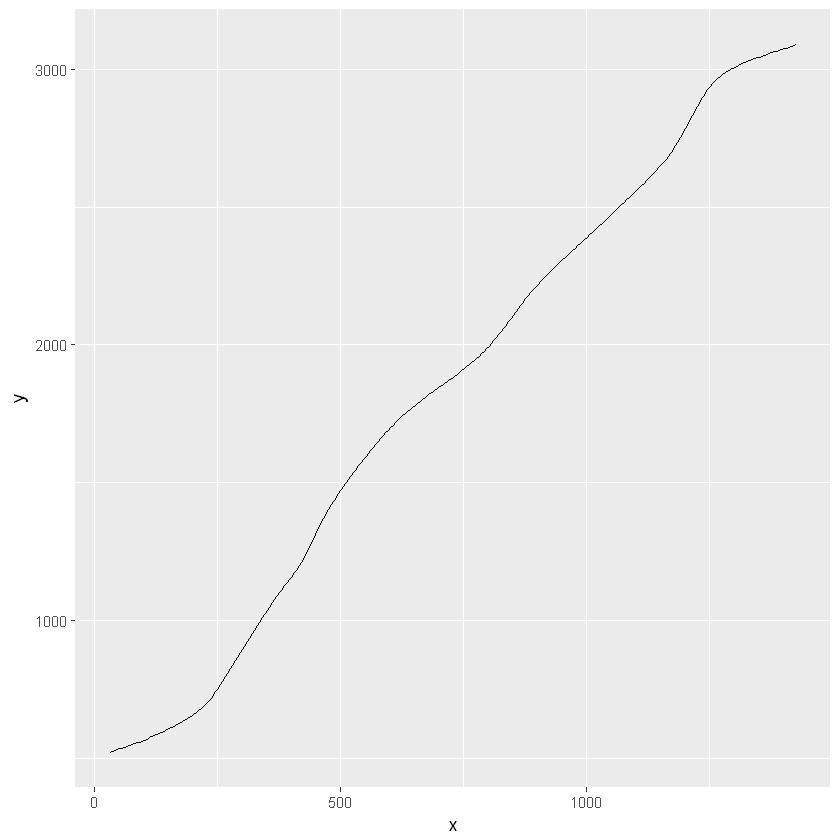

In [132]:
raw_prior_data %>%
    filter(pid == 'a008', scenario == 'Sales') %>%
    ggplot(aes(x, y)) + geom_line()

## Posterior 

In [308]:
# Sequence of days to analyze:
new_sequence = seq(31, 1426, 5)

In [349]:
# Inner join. 
# This is the predictions data merged with the best performing (and filtered) kernels in the posterior condition
new_pred <- merge( 
            # Predictions (full-Bayesian):
            x = predictions %>%
                    filter(day %in% new_sequence),

            # Kernels after the filters:
            y = lmls_posterior_ff %>%
                    select(cid=id, pid, scenario, kernel, lml),

            by = c('cid', 'kernel')
)

# Participants' data
new_participants_data <- dat %>% 
                        filter(#day > 365-31, #remove evidence
                               condition != 'Prior', #only Posterior conditions
                               day %in% new_sequence) %>%
                        select(pid = id, day, value_participant=value, scenario, condition, noise)

# Merge the predictions with the real participants' data
new_all_pred_data <- merge(
                # Predictions + Kernel posterior analysis:
                x = new_pred,
    
                # Participant's data:
                y = new_participants_data,
    
                by = c('pid', 'scenario', 'day')
)

In [350]:
# New error dataset (mean-error per participant per scenario per model)
new_error_per_participant <- new_all_pred_data %>%
                            #filter(day <= 365*2) %>% # To Eric: this is something I though about. What do you think about it?
                            group_by(pid, scenario, kernel, lml) %>% 
                            summarize(error = calculate_mean_error(value, value_participant))


new_error_per_participant <- add_is_max_column(new_error_per_participant)


new_error_per_participant <- new_error_per_participant %>%
                                filter(kernel == 'r' | is_max)

# Remove those [pid, kernel] combinations where the R kernel was not present (because it was previously filtered out)
new_error_per_participant_ff <- new_error_per_participant %>%
                                group_by(pid, scenario) %>%
                                filter(length(kernel) > 1)

In [351]:
to_plot_post <- merge(
                    x = new_all_pred_data,
                    y = new_error_per_participant_ff %>% select(pid, scenario, kernel) %>% unique
                )

to_plot_post$id <- paste(to_plot_post$cid, to_plot_post$kernel)

In [352]:
# Temperature: a001, a010, a012

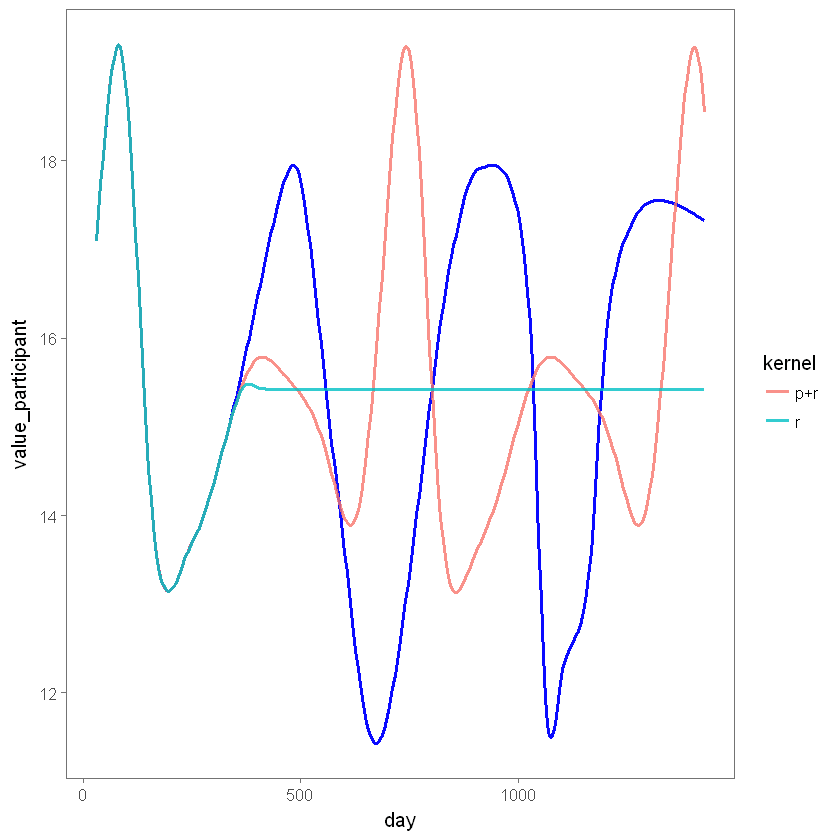

In [366]:
to_plot_post %>% 
    filter(scenario == 'Temperature',
           pid == 'a001' ) %>%
    ggplot() +
    geom_line(aes(x=day, y=value_participant, group=id), color='blue', size=1, alpha=0.8) +
    geom_line(aes(x=day, y=value, group=kernel, color=kernel), size=1, alpha=0.8) +
    ggthemes::theme_few()